In [ ]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras

from keras import layers, regularizers
import cv2
from keras import backend as K
import os
import glob
import re
import gc
# from google.colab.patches import cv2_imshow
from keras.models import Sequential, Model, load_model
from keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    Reshape,
    Input,
)
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(physical_devices)
# if physical_devices:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Cell 2: Define Constants and Custom Loss
HEIGHT = 64
WIDTH = 64

def weighted_mse(yTrue, yPred):
    ones = K.ones_like(yTrue[0, :])
    idx = K.cumsum(ones)
    return K.mean((1 / idx) * K.square(yTrue - yPred))


In [4]:
# Cell 3: Image Manipulation Functions

# rotate image by a given angle
def rotateImage(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    return cv2.warpAffine(image, M, (nW, nH))


In [5]:
# Cell 4: Data Split Function
def splitter():
    train_files = []
    validation_files = []
    test_files = []
    folders = glob.glob("data/*")
    train_pca = []
    print(folders)
    for folder in folders:
        folder_files = [x for x in os.listdir(folder) if x.endswith(".jpg")]

        for file in folder_files:
            csv_file = file.replace(".jpg", ".csv")
            file = os.path.join(folder, file)

            try:
                csv_file = os.path.join(folder, csv_file)
                csv_file = pd.read_csv(csv_file)
                if csv_file.shape[0] == 205:

                    prob = np.random.random()
                    if prob < 0.02:
                        test_files.append(file)
                    elif 0.02< prob <0.12:
                        validation_files.append(file)
                    else:
                        train_files.append(file)
            except:
                continue

    print(len(train_files))
    print(len(validation_files))
    print(len(test_files))
    return train_files, test_files, validation_files

train_files, test_files, validation_files = splitter()

['data/60d65h', 'data/0d75h', 'data/30d75h', 'data/30d65h', 'data/60d75h', 'data/0d65h']
2966
350
62


[0.4743219  0.1160304  0.07553264 0.0649673  0.04848727 0.03698238
 0.03017349 0.02222771 0.01885663 0.01396535 0.01235224 0.00981924
 0.00885257 0.00719551 0.00581506 0.0053624  0.00435936 0.00395283
 0.00355947 0.00306716]


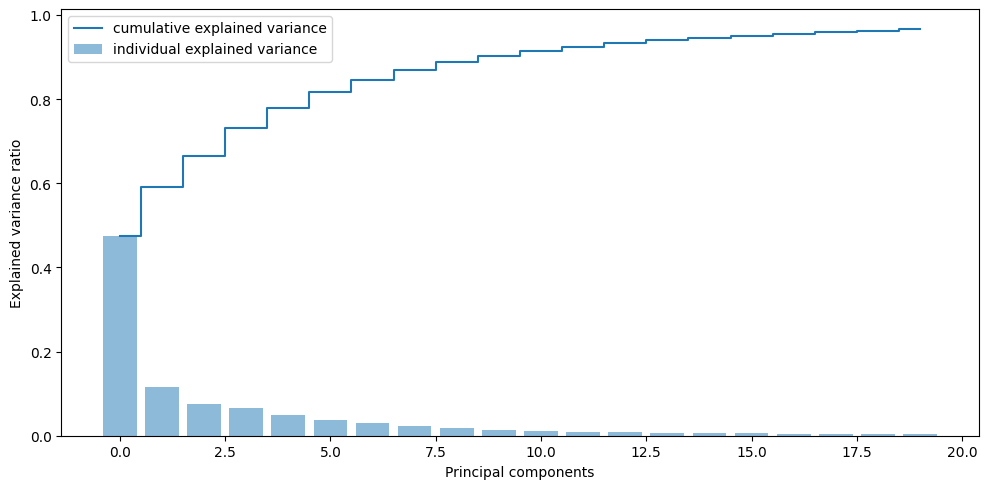

0.9658809018807019


In [6]:
# Cell 5: PCA Function
def PCA_Done(train_files):
    data = np.zeros((len(train_files), 201))

    for i, file in enumerate(train_files):
        label_name = file.replace(".jpg", ".csv")
        if os.path.exists(label_name):
            label_file = pd.read_csv(
                label_name, skiprows=[0, 1, 2, 3, 4], names=["freq", "values"]
            )
            data[i, :] = label_file["values"].astype(float)

    # using the training files fit pca
    pca = PCA(n_components=20)
    pca.fit(data)
    explained_var = pca.explained_variance_ratio_
    print(explained_var)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(len(explained_var)), np.cumsum(explained_var), where='mid', label='cumulative explained variance')
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print(sum(pca.explained_variance_ratio_))
    return pca
pca = PCA_Done(train_files)


In [7]:
# Cell 6: Batch Generator
def batch_generator(pca, X, batch_size=64):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.randint(low=0, high=len(X), size=batch_size)

        images = []
        props = []
        batch_label = []

        # Read in each input, perform preprocessing and get labels
        for input_path_index in batch_paths:
            file = X[input_path_index]

            img = cv2.imread(file, 0)

            folder = os.path.split(os.path.split(file)[0])[1]
            if folder == "0d65h" or folder == "0d75h":
                angle = np.random.randint(0, 360)
                img = rotateImage(img, angle)
            img = cv2.resize(img, (HEIGHT, WIDTH))

            img = img / 255
            img = img.reshape(img.shape[0], img.shape[1], 1)
            prop = re.findall("\d+", folder)
            prop = [int(x) for x in prop]

            prop[0] = prop[0] / 60
            prop[1] = prop[1] / 75

            prop1 = np.full((HEIGHT, WIDTH, 1), prop[0])
            prop2 = np.full((HEIGHT, WIDTH, 1), prop[1])

            props = np.concatenate((prop1, prop2), axis=2)
            # combine properties to images as additional channels
            img = np.concatenate((img, props), axis=2)
            images.append(img)
            # props.append(prop)
            label_name = file.replace(".jpg", ".csv")

            label_file = pd.read_csv(
                label_name, skiprows=[0, 1, 2, 3, 4], names=["freq", "values"]
            )
            label_file["values"] = label_file["values"].astype(float)
            label = label_file["values"].values
            label = pca.transform(label.reshape(1, -1)).reshape(-1,)


            batch_label.append(label)

        batch_x = np.array(images)
        batch_y = np.array(batch_label)

        yield (batch_x, batch_y)
train_gen = batch_generator(pca, train_files)
valid_gen = batch_generator(pca, validation_files, batch_size=8)
test_gen = batch_generator(pca, test_files, 1)

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/v3/bk349gcs0fv4vrdxzx45yjh80000gn/T/ipykernel_72122/4130353160.py:25: SyntaxWarning: invalid escape sequence '\d'
  prop = re.findall("\d+", folder)


In [ ]:
# Cell 7: Model Building Function
def build_vit_model(image_size, num_classes, num_heads=4, num_transformer_layers=4):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    # Convert image to patches
    patch_size = 8  # Define the patch size
    num_patches = (image_size // patch_size) ** 2
    patch_dim = (
        64  # This should be the number of channels times the flattened patch size
    )
    patches = layers.Conv2D(
        filters=patch_dim,
        kernel_size=(patch_size, patch_size),
        strides=(patch_size, patch_size),
    )(inputs)
    patches = layers.Reshape((num_patches, patch_dim))(patches)

    # Positional encoding
    pos_enc = layers.Embedding(input_dim=num_patches, output_dim=patch_dim)(
        tf.range(start=0, limit=num_patches, delta=1)
    )
    patches += pos_enc

    # Transformer layers
    for _ in range(num_transformer_layers):
        # Layer Normalization 1
        x = layers.LayerNormalization(epsilon=1e-6)(patches)
        # Multi-head attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=patch_dim)(
            x, x
        )
        x = layers.Add()([x, attn_output])

        # Layer Normalization 2
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward network
        ffn = layers.Dense(128, activation="relu")(x)
        ffn = layers.Dense(patch_dim)(ffn)
        patches = layers.Add()([x, ffn])
    aggregated = layers.GlobalAveragePooling1D()(patches)
    output = layers.Dense(20, activation="linear")(aggregated)  # num_pca_components should be 20 in your case
    model = Model(inputs=inputs, outputs=output)
    return model

model = build_vit_model(64, 1)  # Replace 256 with your actual image size
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=weighted_mse,
    metrics=["mae"],
)
print(model.summary())
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "iteration_5.h5", save_weights_only=True, save_best_only=True, mode="min"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.8,
        patience=100,
        min_lr=1e-5,
        min_delta=0.000001,
        verbose=1,
        mode="min",
    )
]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     12352       ['input_2[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 64, 64)       0           ['conv2d_1[0][0]']               
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 64, 64)      0           ['reshape_1[0][0]']              
 mbda)                                                                                      

In [ ]:

# CODE FOR HYPERPARAMETERS TUNING

# from kerastuner.tuners import RandomSearch

# def build_model(hp):
#     model = build_vit_model(
#         image_size=hp.Int('image_size', min_value=32, max_value=256, step=32),
#         num_classes=10,
#         num_heads=hp.Int('num_heads', min_value=2, max_value=8, step=2),
#         num_transformer_layers=hp.Int('num_transformer_layers', min_value=1, max_value=8, step=1)
#     )
#     model.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])
#     return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=5,  # number of different hyperparameter configurations to try
#     executions_per_trial=3,  # number of times to train each model, to average out the metrics
#     directory='random_search',
#     project_name='vit'
# )

# tuner.search(train_gen, epochs=5, validation_data=(valid_gen))

In [ ]:
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [9]:

def preprocess_image(file, HEIGHT, WIDTH, rotate_if_needed):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)

    if rotate_if_needed:
        angle = np.random.randint(0, 360)
        img = rotateImage(img, angle)  # Rotate the image

    # Resize the image to the desired dimensions after rotation
    img = cv2.resize(img, (WIDTH, HEIGHT))

    # Now the reshape should work as the size is enforced to be HEIGHT x WIDTH
    img = img.reshape(HEIGHT, WIDTH, 1) / 255.0
    return img

def extract_properties(folder):
    prop = [int(x) for x in re.findall("\d+", folder)]
    return np.array([prop[0] / 60, prop[1] / 75])

from sklearn.metrics import mean_squared_error

def prediction(test_files, model, pca, HEIGHT, WIDTH, batch_size=5):
    for i in range(0, len(test_files), batch_size):
        batch_files = test_files[i:i + batch_size]
        batch_images = []
        batch_props = []

        for file in batch_files:
            folder = os.path.split(os.path.split(file)[0])[1]
            rotate_if_needed = folder in ["0d65h", "0d75h"]
            img = preprocess_image(file, HEIGHT, WIDTH, rotate_if_needed)
            props = extract_properties(folder)
            prop1 = np.full((HEIGHT, WIDTH, 1), props[0])
            prop2 = np.full((HEIGHT, WIDTH, 1), props[1])
            img_with_props = np.concatenate((img, prop1, prop2), axis=2)
            batch_images.append(img_with_props.reshape(HEIGHT, WIDTH, 3))

        batch_images = np.array(batch_images)
        predictions = model.predict(batch_images)
        predictions = pca.inverse_transform(predictions)

        for j, file in enumerate(batch_files):
            label_name = file.replace(".jpg", ".csv")
            label_file = pd.read_csv(label_name, skiprows=5, names=["freq", "values"])
            label_file["values"] = label_file["values"].astype(float)
            label = label_file["values"].values
            pred_values = predictions[j].reshape(-1)
            
            # Plotting the predictions and actual values
            plt.figure()
            plt.ylim(-1, 1)
            plt.plot(pred_values, label='Predicted')
            plt.plot(label, label='Actual')
            plt.legend()
            plt.show()

            # Calculating and printing the MSE for each prediction
            mse = mean_squared_error(label, pred_values)
            print(f"MSE for {os.path.basename(file)}: {mse}")

    K.clear_session()
    gc.collect()



<>:16: SyntaxWarning: invalid escape sequence '\d'
<>:16: SyntaxWarning: invalid escape sequence '\d'
/var/folders/v3/bk349gcs0fv4vrdxzx45yjh80000gn/T/ipykernel_72122/4046077479.py:16: SyntaxWarning: invalid escape sequence '\d'
  prop = [int(x) for x in re.findall("\d+", folder)]


In [ ]:
# model.load_weights('best_model_v2.h5')

history = model.fit(
    train_gen,
    epochs=2000,
    verbose=1,
    batch_size=32,
    validation_data=valid_gen,
    validation_steps=len(validation_files) // 8,
    steps_per_epoch=len(train_files) // 32,
    callbacks=callbacks,
)

model.save_weights('iteration_5_weights.h5')

model.save('iteration_5_model.h5')

Epoch 1/2000
93/93 [==============================] - 78s 775ms/step - loss: 0.0556 - mae: 0.2571 - val_loss: 0.0278 - val_mae: 0.1768 - lr: 1.0000e-04
Epoch 2/2000
93/93 [==============================] - 37s 396ms/step - loss: 0.0252 - mae: 0.1765 - val_loss: 0.0163 - val_mae: 0.1503 - lr: 1.0000e-04
Epoch 3/2000
93/93 [==============================] - 30s 329ms/step - loss: 0.0185 - mae: 0.1470 - val_loss: 0.0148 - val_mae: 0.1372 - lr: 1.0000e-04
Epoch 4/2000
93/93 [==============================] - 29s 319ms/step - loss: 0.0187 - mae: 0.1373 - val_loss: 0.0148 - val_mae: 0.1258 - lr: 1.0000e-04
Epoch 5/2000
93/93 [==============================] - 28s 308ms/step - loss: 0.0183 - mae: 0.1343 - val_loss: 0.0125 - val_mae: 0.1196 - lr: 1.0000e-04
Epoch 6/2000
93/93 [==============================] - 28s 305ms/step - loss: 0.0175 - mae: 0.1289 - val_loss: 0.0163 - val_mae: 0.1257 - lr: 1.0000e-04
Epoch 7/2000
93/93 [==============================] - 28s 304ms/step - loss: 0.0180 - ma

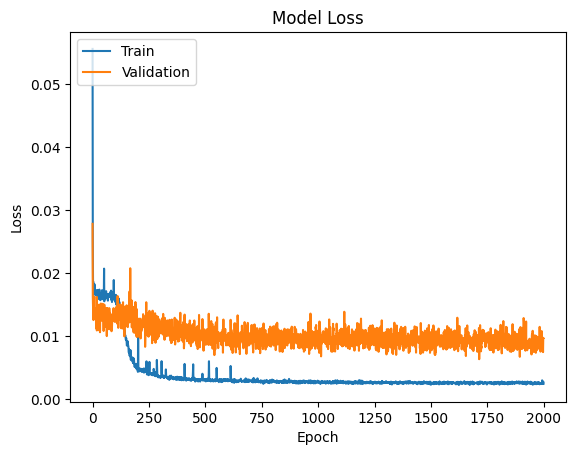

In [ ]:
# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# For loading the model if program has been terminated

model1 = load_model('iteration_5_model.h5',custom_objects={"weighted_mse" : weighted_mse})
print(model1.summary())

print(f"Test Loss: {model1.evaluate(test_gen, steps=len(test_files))}")

ValueError: Unknown layer: 'TFOpLambda'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

1/1 [==============================] - 0s 473ms/step
(201,)


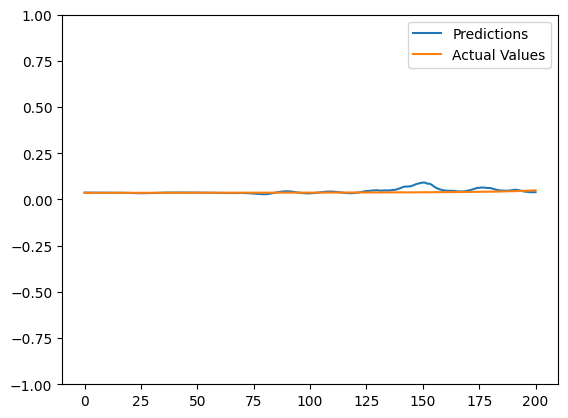

(201,)


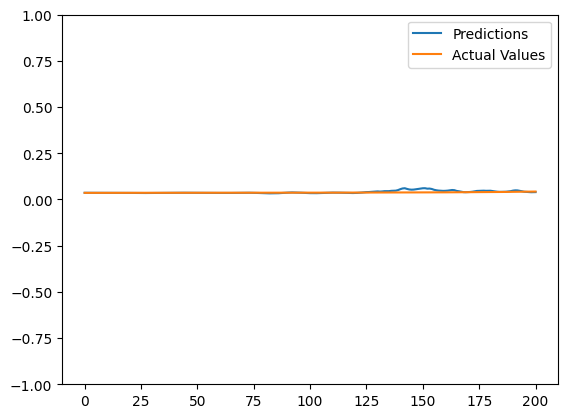

(201,)


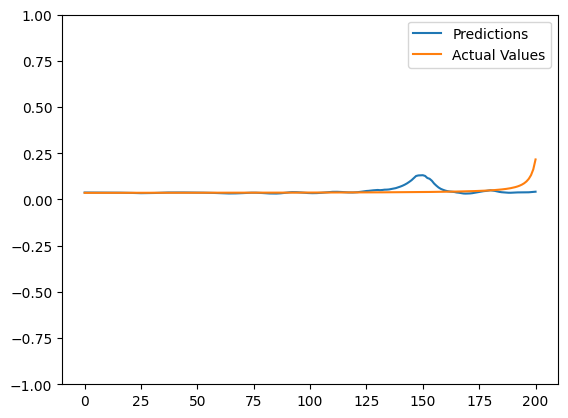

(201,)


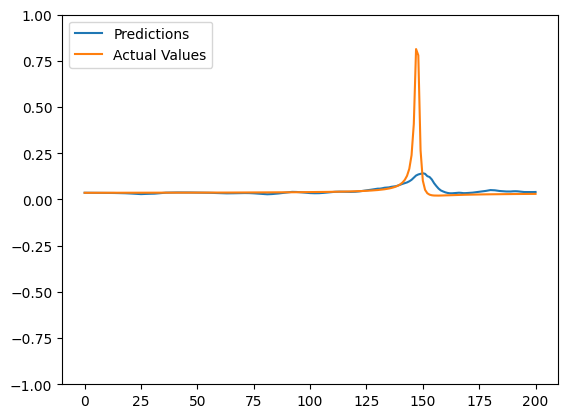

(201,)


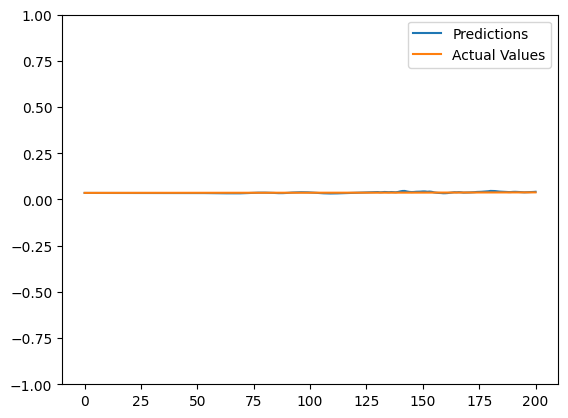

1/1 [==============================] - 0s 44ms/step
(201,)


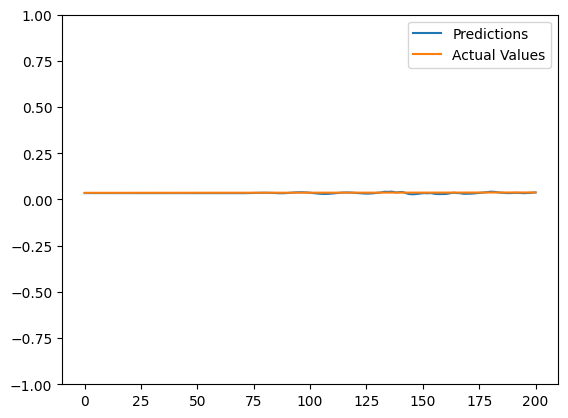

(201,)


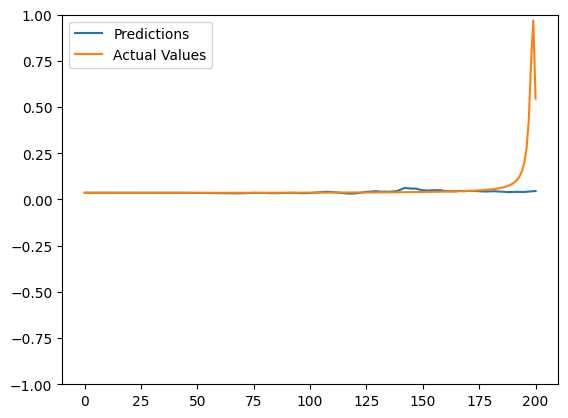

(201,)


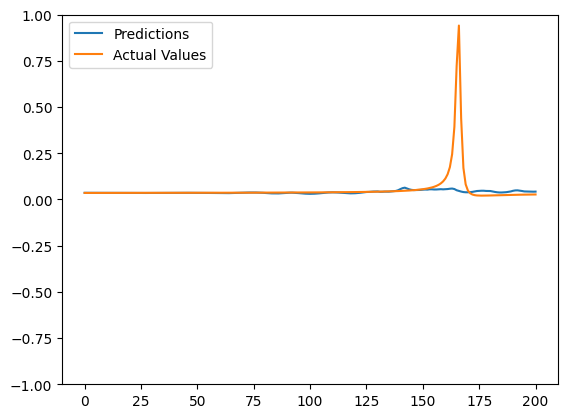

(201,)


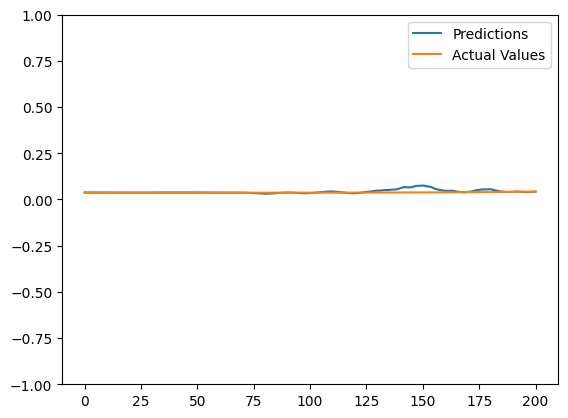

(201,)


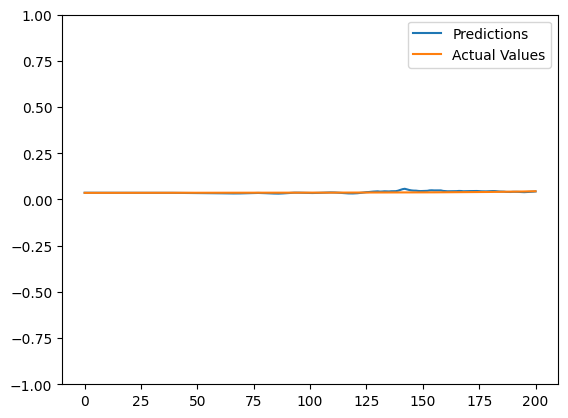

1/1 [==============================] - 0s 32ms/step
(201,)


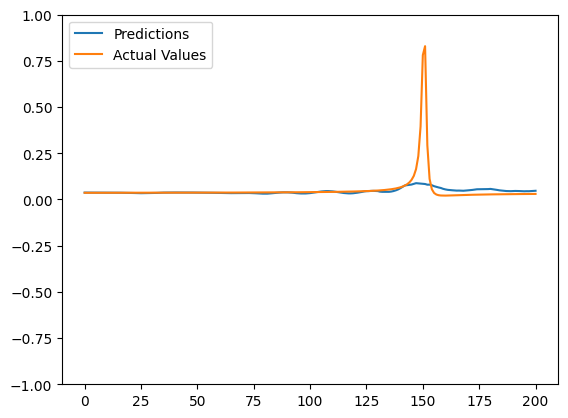

(201,)


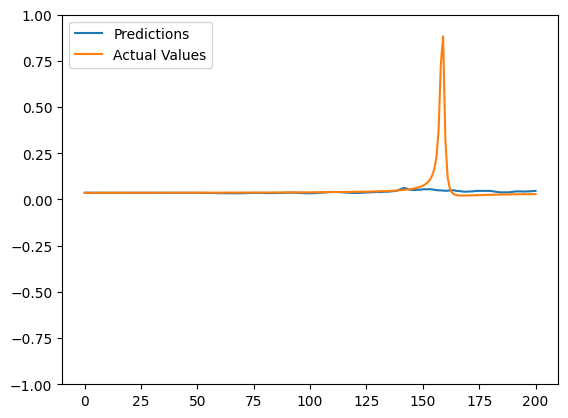

(201,)


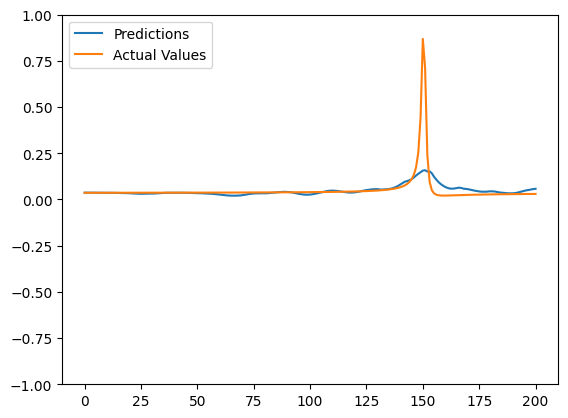

(201,)


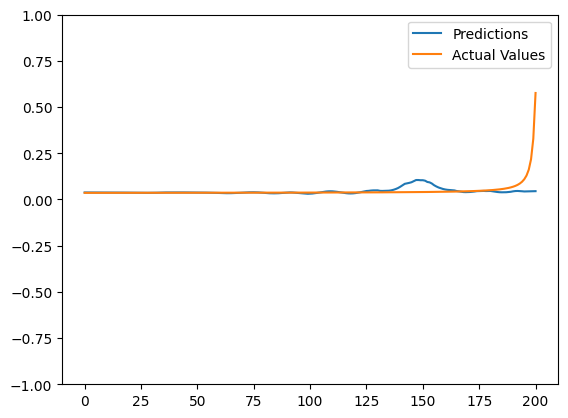

(201,)


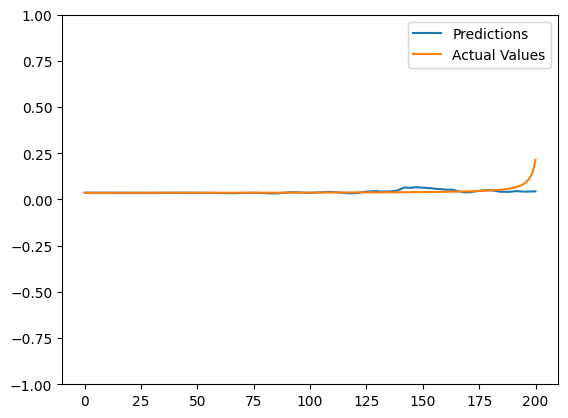

1/1 [==============================] - 0s 69ms/step
(201,)


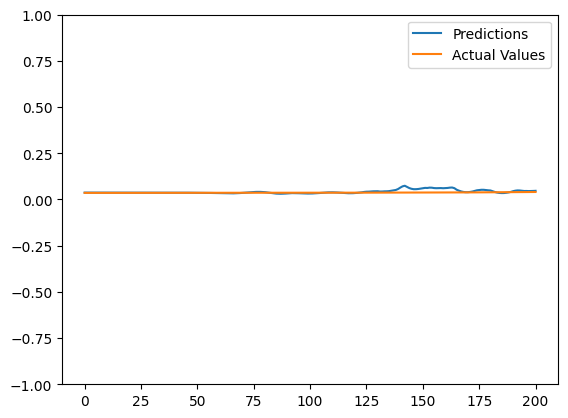

(201,)


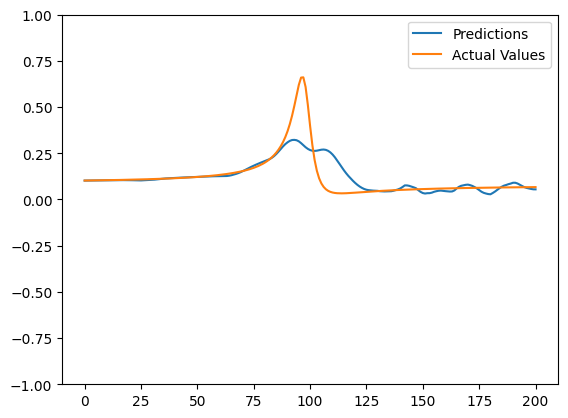

(201,)


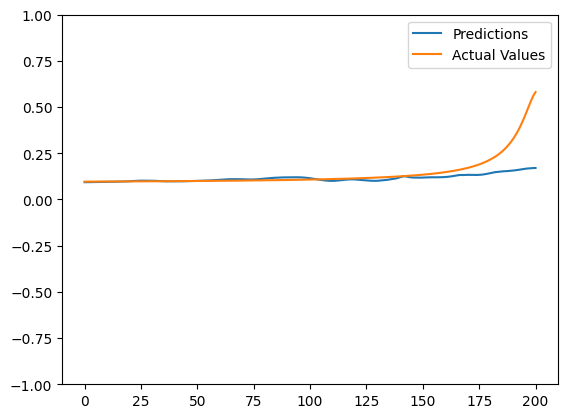

(201,)


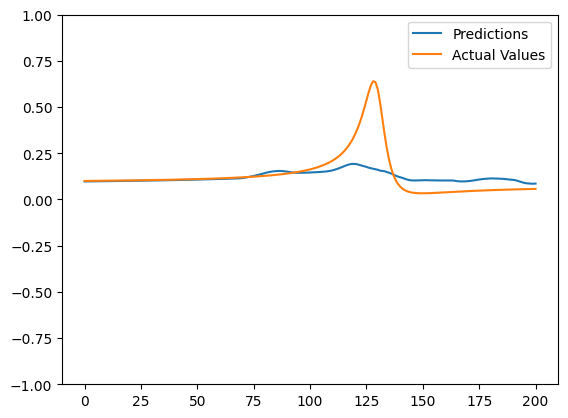

(201,)


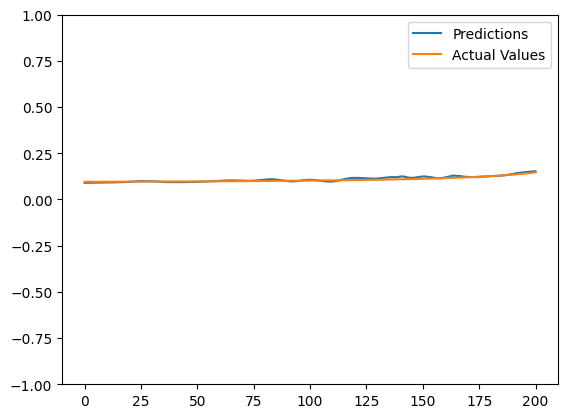

1/1 [==============================] - 0s 52ms/step
(201,)


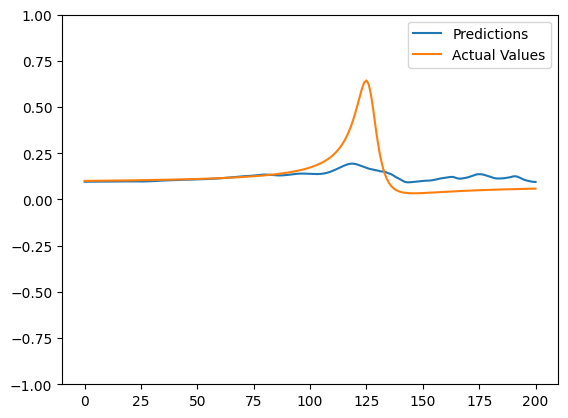

(201,)


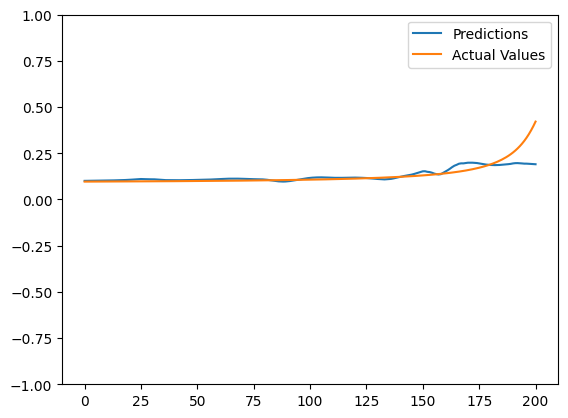

(201,)


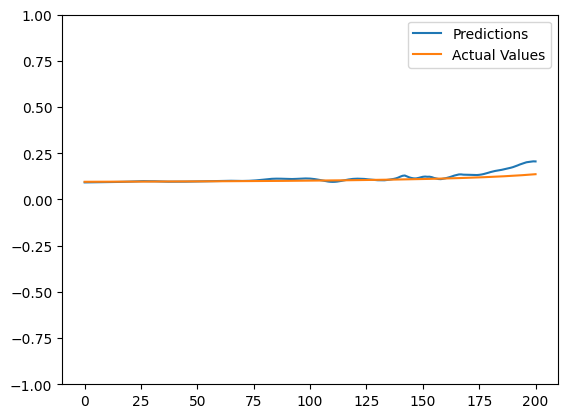

(201,)


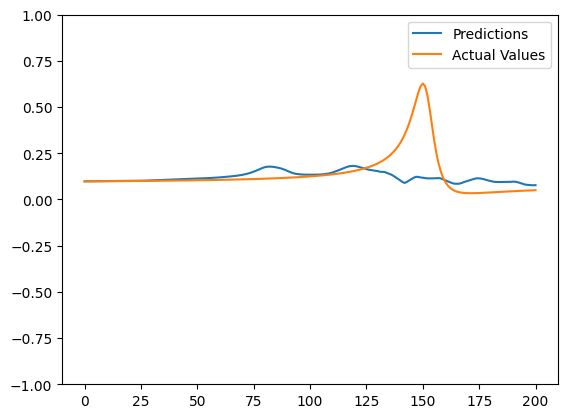

(201,)


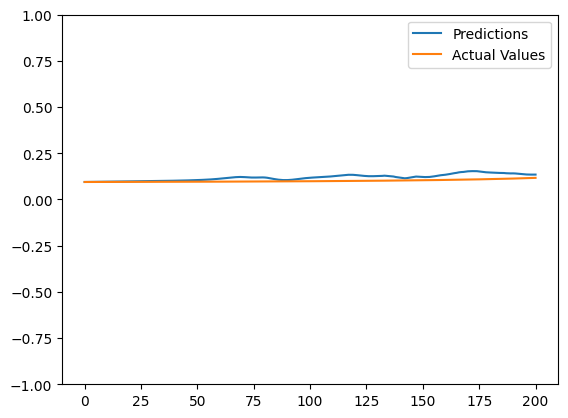

1/1 [==============================] - 0s 41ms/step
(201,)


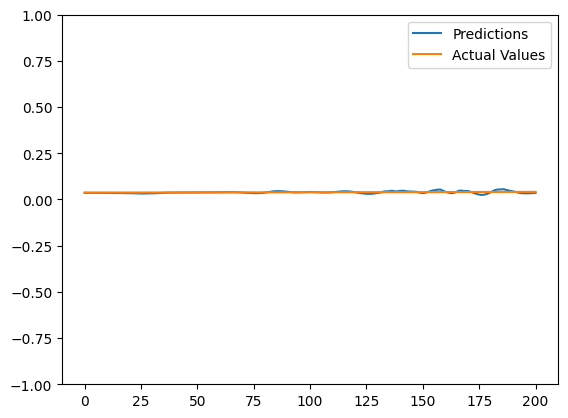

(201,)


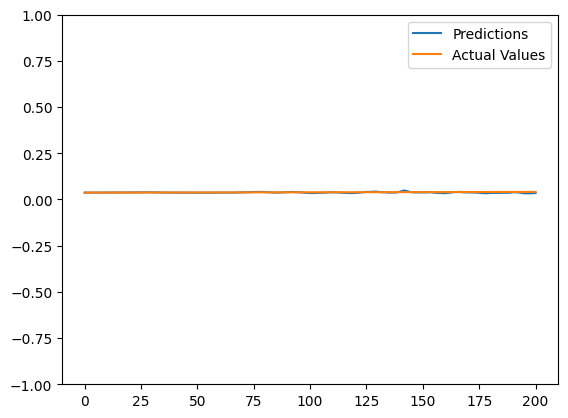

(201,)


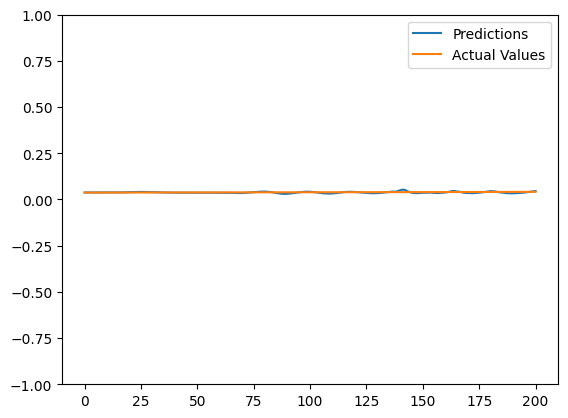

(201,)


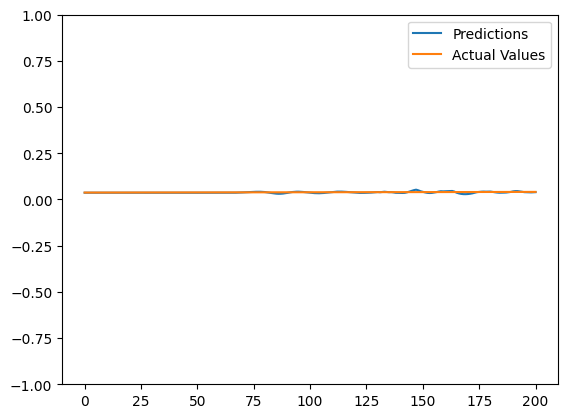

(201,)


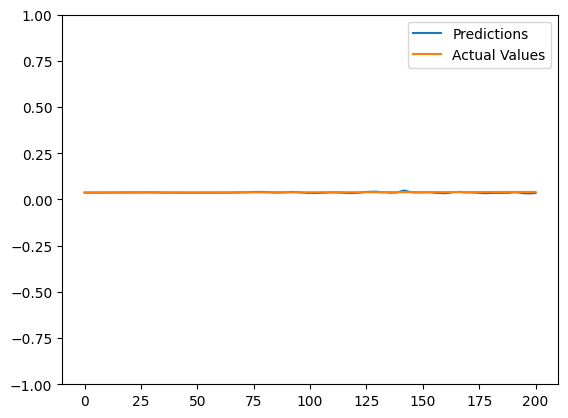

1/1 [==============================] - 0s 31ms/step
(201,)


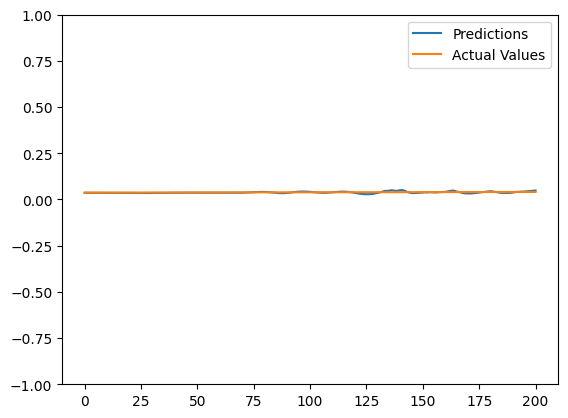

(201,)


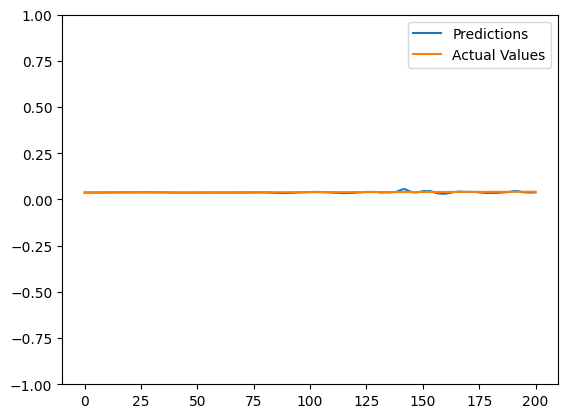

(201,)


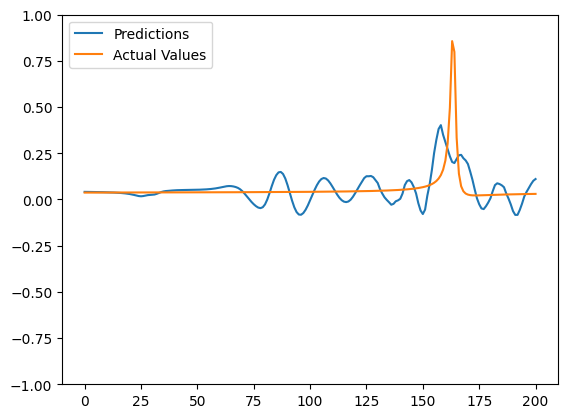

(201,)


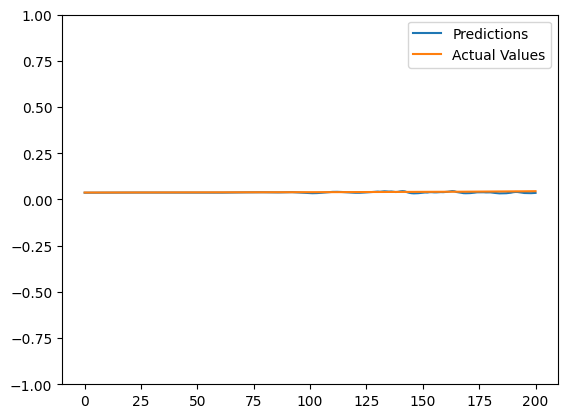

(201,)


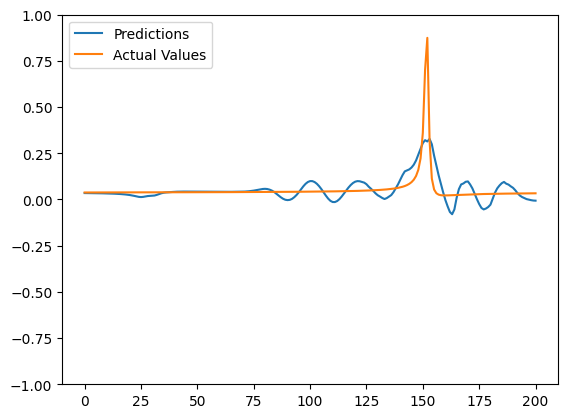

1/1 [==============================] - 0s 44ms/step
(201,)


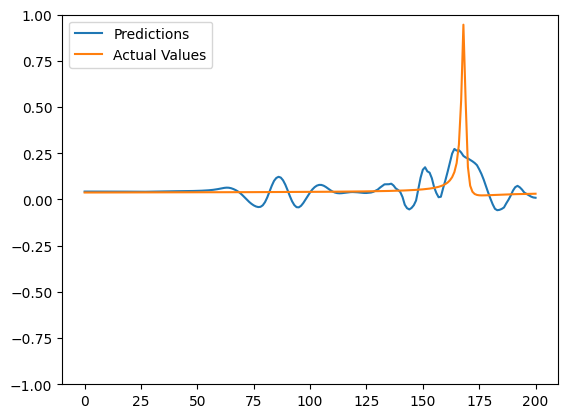

(201,)


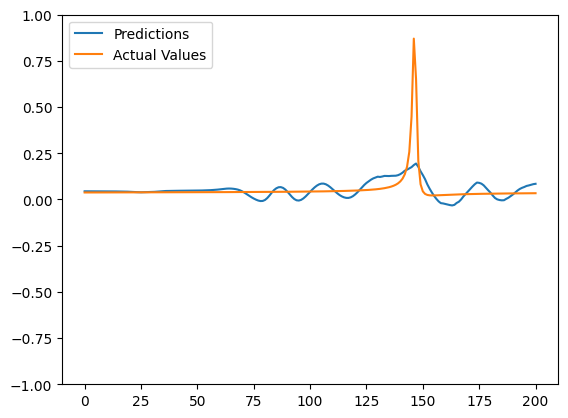

(201,)


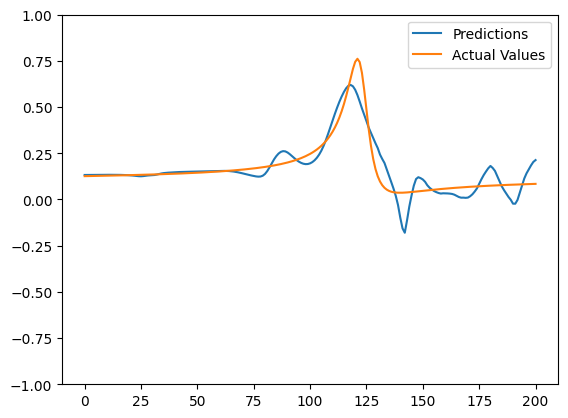

(201,)


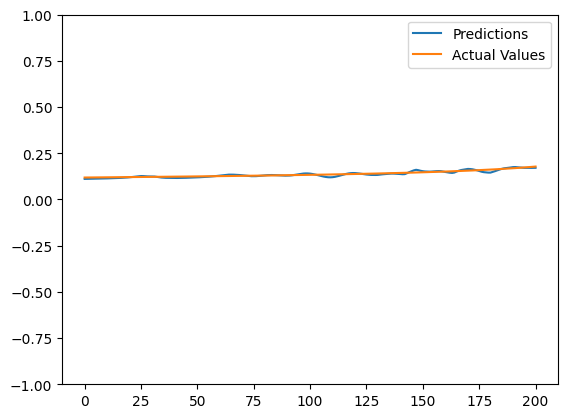

(201,)


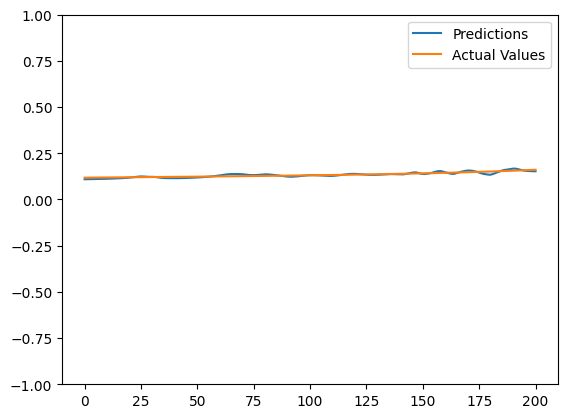

1/1 [==============================] - 0s 31ms/step
(201,)


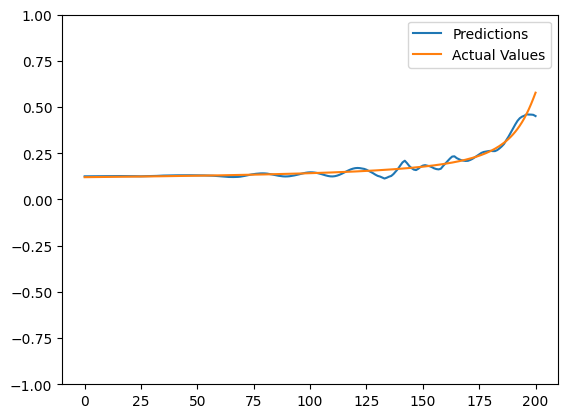

(201,)


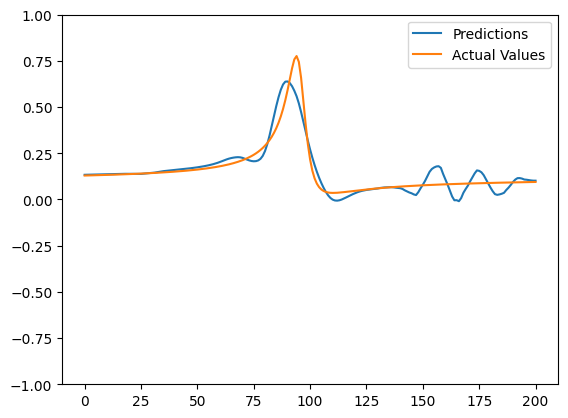

(201,)


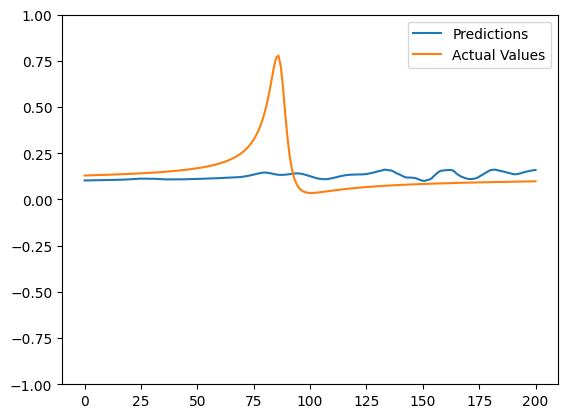

(201,)


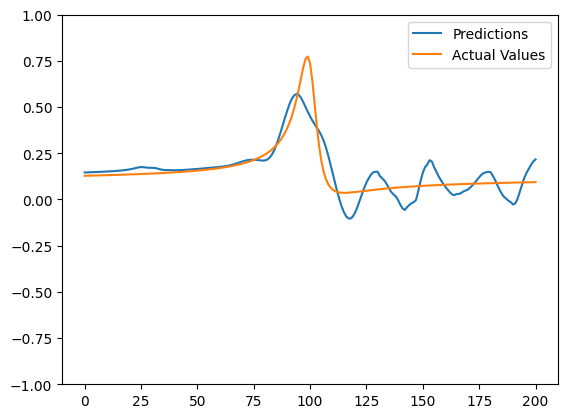

(201,)


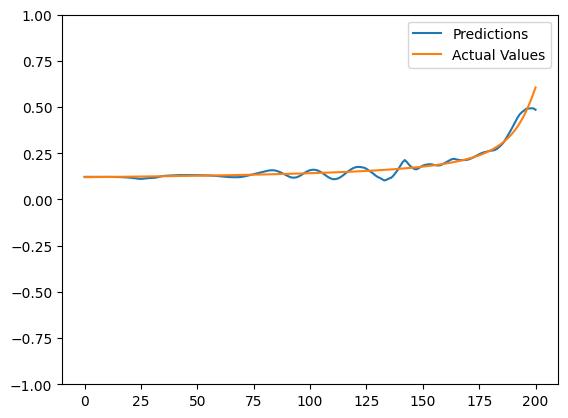

1/1 [==============================] - 0s 43ms/step
(201,)


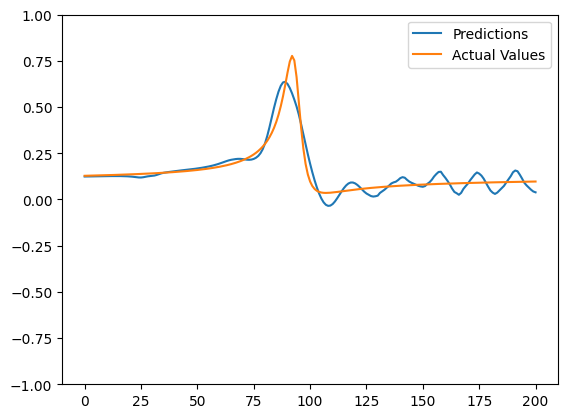

(201,)


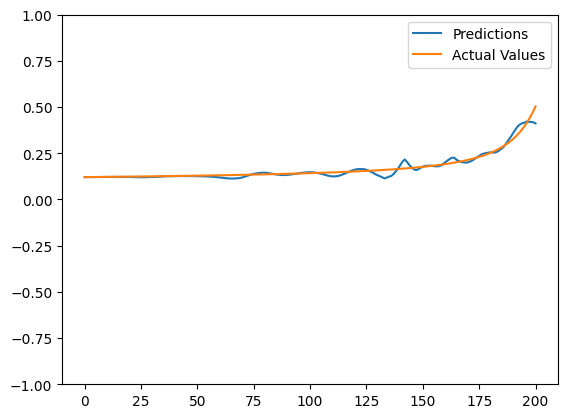

(201,)


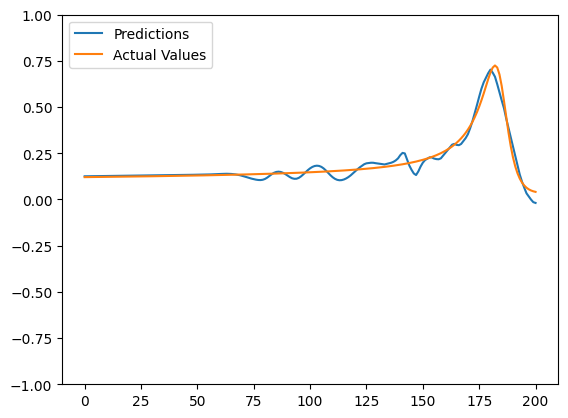

(201,)


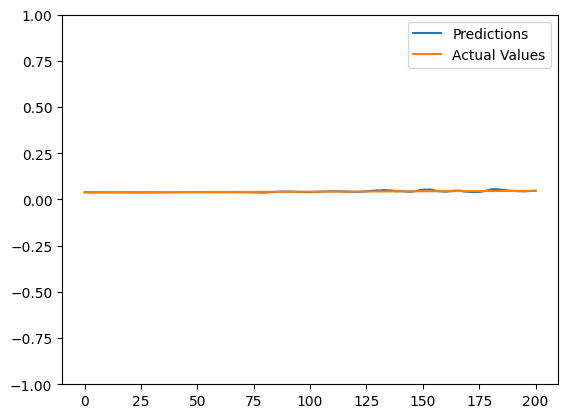

(201,)


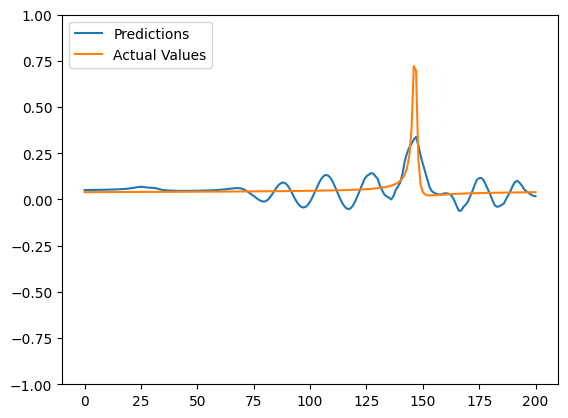

1/1 [==============================] - 0s 40ms/step
(201,)


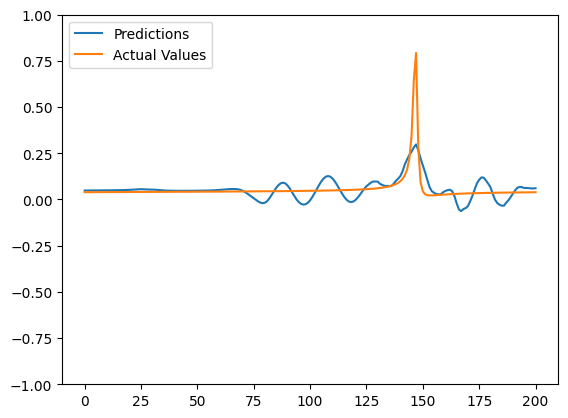

(201,)


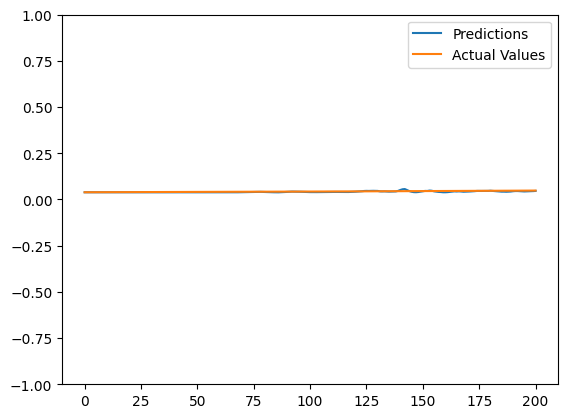

(201,)


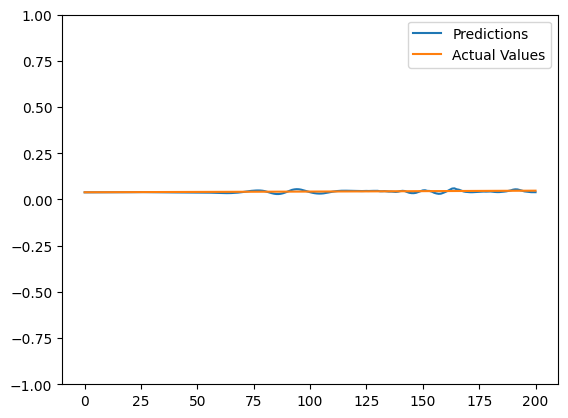

(201,)


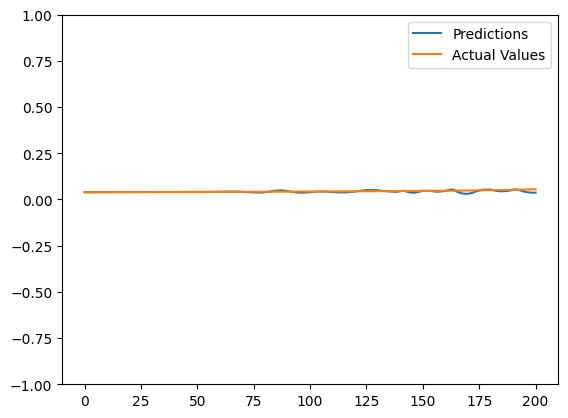

(201,)


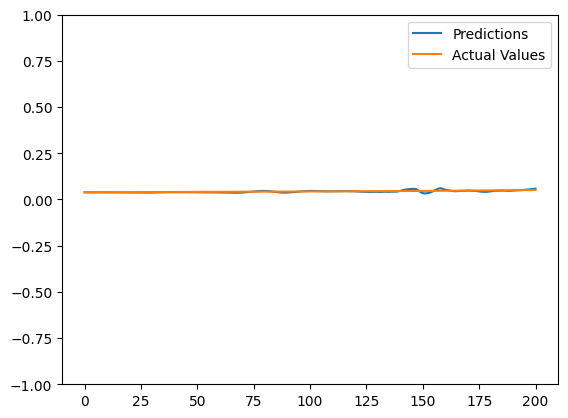

1/1 [==============================] - 0s 35ms/step
(201,)


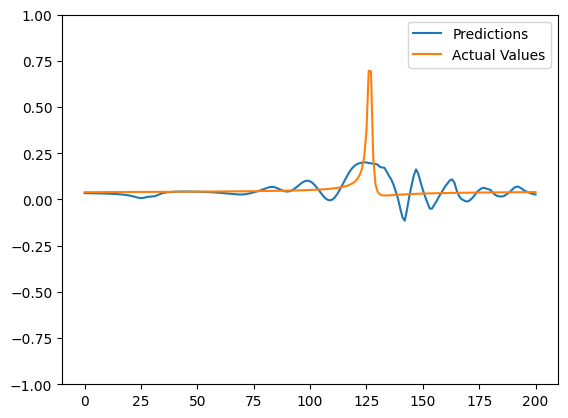

(201,)


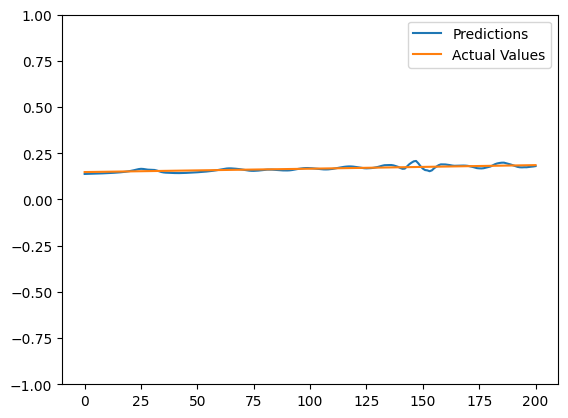

(201,)


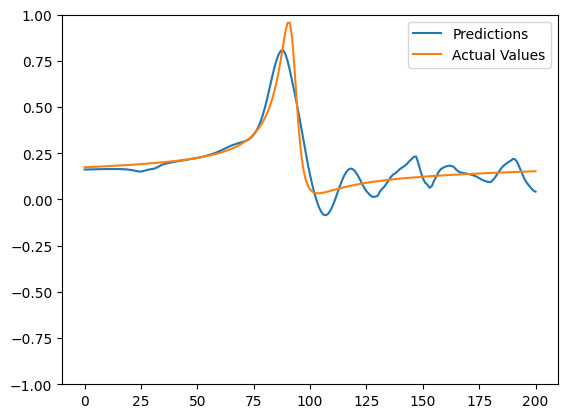

(201,)


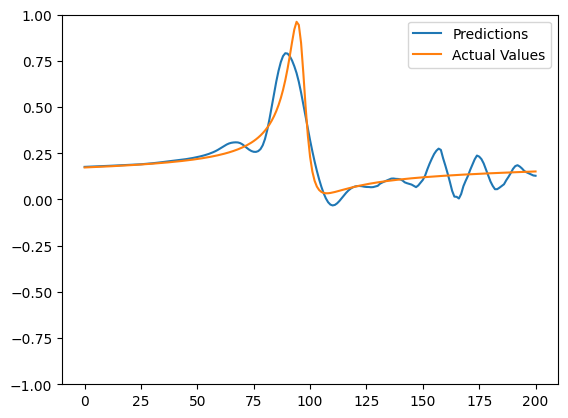

(201,)


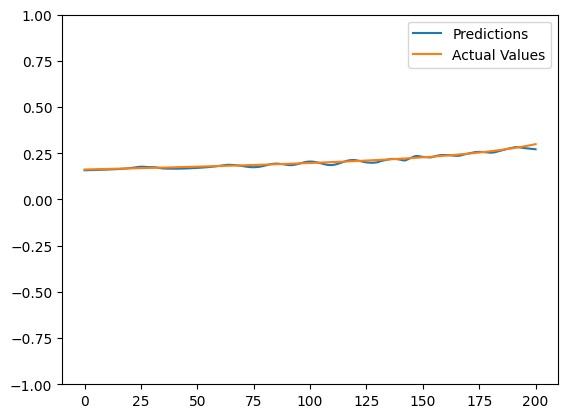

1/1 [==============================] - 0s 33ms/step
(201,)


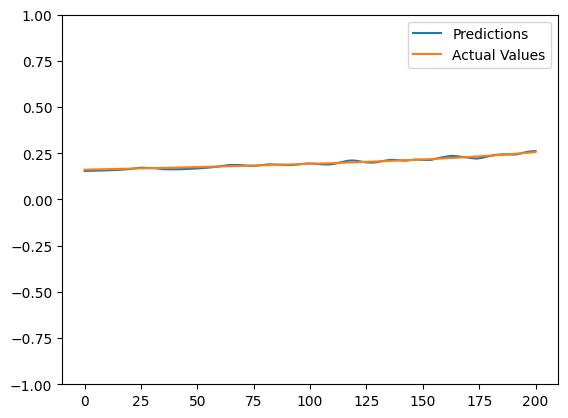

(201,)


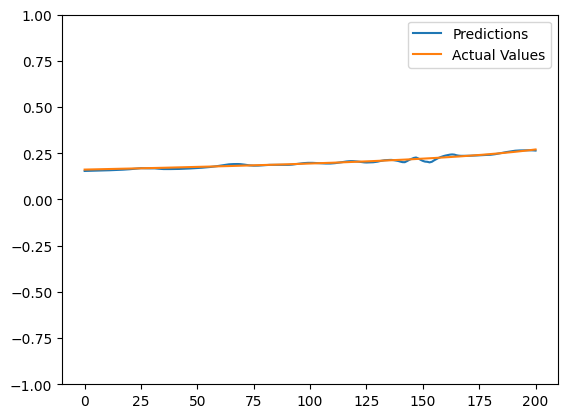

(201,)


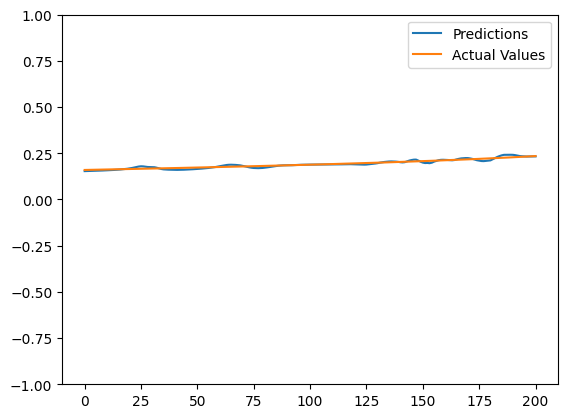

(201,)


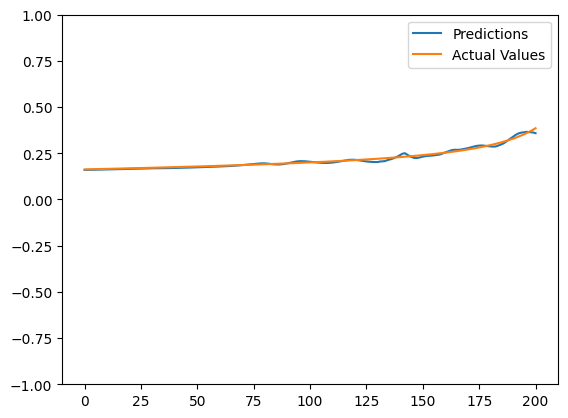

(201,)


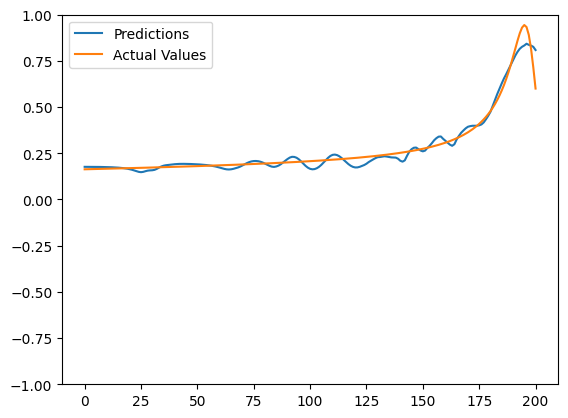

1/1 [==============================] - 0s 34ms/step
(201,)


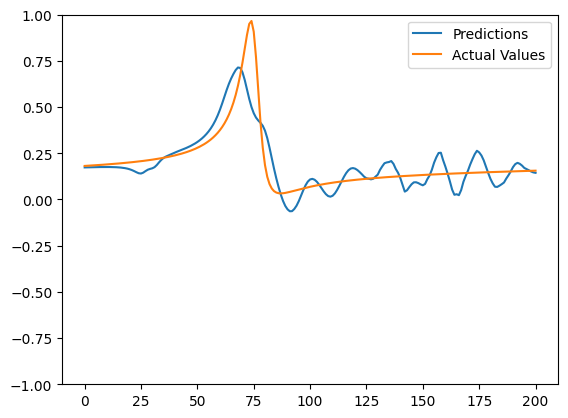

In [ ]:
prediction(test_files, model1, pca, HEIGHT, WIDTH)